# Dark Matter Density: Heat Map from GAIA3 Data

In this notebook we are going to adopt an axisymmetric Milky Way mass model (e.g. McMillian 2017) to compute $\rho_{DM}(R,z)$ along the plane (z=0) and high above it where the halo resides (5 - 200 kpc).  To do this we are going to adopt the density profile for the halo which is utilized in McMillan 2017 for our analysis.  We will first plot a heat map of McMillian's density profile so we can see the dark matter distribution in our Milky Way

In the 2nd part, we will pull orbital velocities and galactic coordinates from GAIA3 for millions of stars.  We will calculate the expected velocity via mewtonian mechanics for each star and calculate the difference in velocities.  This difference will be the amount of contribution to the orbital velocity from dark matter.  We can convert that orbital velocity contribution into a mass, and carefully transform it into a density value for that stars location.  A heat map will be created for the calculated density values.

## 1. McMillian's Density Profile Function

We are going to produce a visual of the dark matter distribution in the Milky Way with McMillian 2017's density profile:

$$ \rho_h = \frac{\rho_{0,h}}{x^{\gamma}(1+x)^{3-\gamma}} $$

with $x = \frac{r}{r_{h}}$.  We will use a NFW (Navarro, Frenk, White) model with $\gamma = 1$ (Navarro et al 1996).  Let us begin initializing constants and our McMillian density profile function.


In [1]:
import numpy as np
import pandas as pd  
import astropy.units as u


    

G = 4.302e-6                   ## kpc*(km/s)**2 / solar mass (Newton's Gravitational Constant)
r_h = 19.0                     ## kpc  / scale radius of the dark matter halo with gamma = 1
gamma = 1.0                    ## nfw model  
R_o = 8.2                      ## solar location in the Milky Way in kpc  

rho_h = 0.00854                ## solar mass / m^-3   (density of the dark matter halo_0 from McMillian 2017)
rho_sun = 0.0101               ## solar mass / m^-3   (local dark matter density)


def rho_dm(R, z, r_halo, g, rho_0):
     
    # r_halo = scale radius, g = gamma, rho_0 = mcmillian density profile
    
    r = np.hypot(R,z)     ##(R**2+z**2)^(0.5)
    
    x = r / r_halo
    
    return rho_0 /(x**(gamma) * (1 + x)**(3-gamma))


We will use this density profile and create a heat map of the density in a 3D graph created with matplotlib.  The heat map will visually show where dark matter is concentrated the most in our galaxy.  

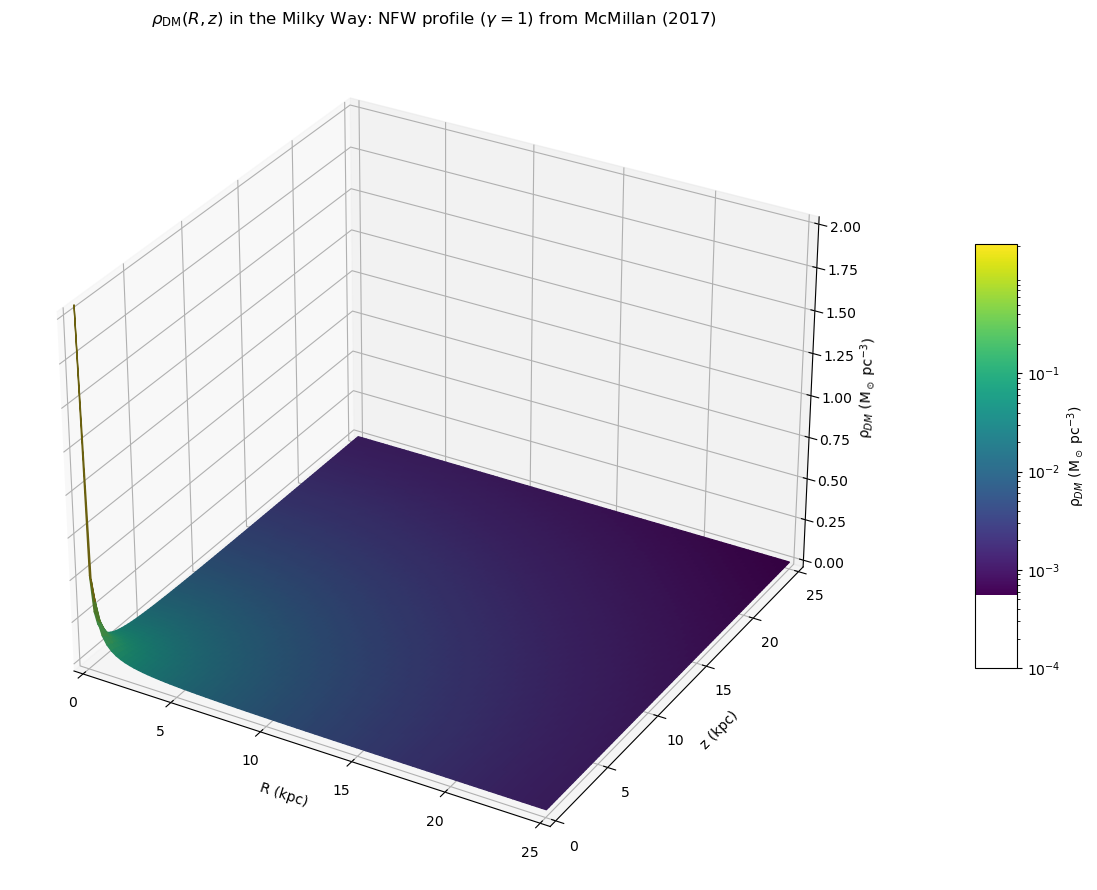

In [2]:
import matplotlib.pyplot as plt
from matplotlib import colors
from mpl_toolkits.mplot3d import Axes3D


def plot_rho_dm(R_HALO, GAMMA, RHO_0):
    
    # create 
    R = np.linspace(0.055, 25, 100)
    Z = np.linspace(0.055, 25, 100)
    
    R_meshg, Z_meshg = np.meshgrid(R, Z)
    rho_meshg = rho_dm(R_meshg, Z_meshg, R_HALO, GAMMA, RHO_0)
    
    # — Pure Matplotlib 3D surface plot —
    fig = plt.figure(figsize=(12,9))
    ax  = fig.add_subplot(111, projection='3d')
    
    norm = colors.LogNorm(vmin=rho_meshg.min(), vmax=rho_meshg.max())
    
 #   surf = ax.plot_surface(
 #       R_meshg, Z_meshg, rho_meshg,
 #       rstride=1, cstride=1, cmap='viridis', edgecolor='none'
 #   )
    
    surf = ax.plot_surface(
    R_meshg, Z_meshg, rho_meshg,
    facecolors=plt.cm.viridis(norm(rho_meshg)),
    rstride=1, cstride=1, antialiased=True
    )

    # draw a colorbar manually (for the facecolors you passed in)
    m = plt.cm.ScalarMappable(norm=norm, cmap='viridis')
    m.set_array([])
    cbar = fig.colorbar(m, ax=ax, shrink=0.5, aspect=10, pad=0.1)
    cbar.set_label('ρ$_{DM}$ (M$_\odot$ pc$^{-3}$)')
    cbar.set_ticks([1e-4, 1e-3, 1e-2, 1e-1]) 
    
    ax.set_zlim(0, 2)
    ax.set_xlim(0, 25)
    ax.set_ylim(0, 25)
    
    ax.set_xlabel('R (kpc)')
    ax.set_ylabel('z (kpc)')
    ax.set_zlabel('ρ$_{DM}$ (M$_\odot$ pc$^{-3}$)')
    #ax.set_title('ρ$_{DM}(R, z)$ in the Milky Way Assuming NFW = 1 (McMillan (2017))' )
    ax.set_title(r'$\rho_{\rm DM}(R, z)$ in the Milky Way: NFW profile ($\gamma=1$) from McMillan (2017)')
    
    #fig.colorbar(surf, ax=ax, shrink=0.5, aspect=10, label='ρ_DM')
    
    plt.tight_layout()
    plt.show()
    

plot_rho_dm(r_h, gamma, rho_h)

The graph shows that dark matter has the highest concentration in the bulge and then decreases to 0.00854 $M_\odot / pc^{-3}$.  At around the solar distance from the center (8 kpc) we observe a much larger dark matter density vs outside the scale radius (19.0 kpc).  For both instances we will keep z to be near 0.

In [3]:
# solar distance 
print(rho_dm(R_o, 0.0001, r_h, 1, rho_h))

# past the scale radius @ 25 kpc
print(rho_dm(25, 0.0001, r_h, 1, rho_h))


0.009655327584510367
0.00121024504130163


We will confirm that this density profile provides enough dark matter mass at the Sun's location in the milky way to justify its rotational speed.  We are going to reconfirm velocities for the Sun and a distant globular cluster with this density profile for dark matter.  We chose Palomar 14 because why not.

The mass of dark matter enclosed within a sphere radius r can be calculated from integrating the density profile 

$$ M(<R) = \int^{r}_{0}r^{'2}\rho_{DM}(r^{'})dr^{'} = 4\pi\rho_{o}R_{S}^{3} \left[ ln(1+r/R_s)-\frac{r/R_s}{1+r/R_s}\right] $$

In [4]:
from scipy.special import i0, i1, k0, k1      # for baryonic velocity calculation for globular clusters

# Virial Velocity due to observable mass for stars in the disk from bulge
def v_bulge(M, R):
    
    return np.sqrt(G * M / R)

# Virial velocity due to the observable mass from the disk (Freeman 1970)
def v_disc(R, Sigma0, Rd):       # distance, disk density, disk radius
    
    # convert Sigma0 to M_sun/kpc^2
    
    Sigma0 *= 1e6
    
    y = R / (2.0 * Rd)
    
    return np.sqrt(
        4 * np.pi * G * Sigma0 * Rd *
        y**2 * (i0(y)*k0(y) - i1(y)*k1(y))
    )

# total velocity contribution from the disk
def v_disk_total(R):
    
    Sigma0_thin, Rd_thin   = 887.0, 2.53
    Sigma0_thick, Rd_thick = 150.0, 3.29
    
    v_thin = v_disc(R, Sigma0_thin, Rd_thin)
    v_thick = v_disc(R, Sigma0_thick, Rd_thick)
    
    return np.sqrt(v_thin**2+v_thick**2)

# Helper: f(x) = ln(1+x) – x/(1+x), this simplifies McMillian's density profile
def f(x):
    return np.log(1 + x) - x/(1 + x)

# NFW DM model circular speed from DM at any spherical radius r (McMillian 2017)
def v_darkmatter(r):

    M200  = 1.30e12         # virial mass (solar masses)
    R200  = 200.0           # virial radius (kiloparsecs)
    Rs    = 19              # scale radius (kiloparsecs)
    
    return np.sqrt( G * M200 / R200  *  f(r/Rs)/f(R200/Rs)  * (R200/r) )

# total velocity for any disk star
def v_component(r):          ## m_int = interior mass, r = distance     # for disk and halo stars
    
    m_bulge = 9.7e9      # total mass of the milky way bulge
    v_baryonic = np.sqrt(v_bulge(m_bulge, r)**2 + v_disk_total(r)**2)     # baryonic contribution
    v_dm = v_darkmatter(r)                                                # dark matter
    v_total = np.sqrt(v_baryonic**2+v_dm**2)   # total velocity

    return v_total, v_baryonic, v_dm
    
# The Sun
z_sun = 0.0    # kpc
R_sun = np.hypot(R_o, z_sun)

v_total_sun, v_bary_sun, v_dm_sun = v_component(R_sun)

print("Velocity Contribution from Baryonic Matter = "+str(v_bary_sun))
print("Velocity Contribution from Dark Matter = "+str(v_dm_sun))
print("Total Velocity = "+str(v_total_sun))
print("Accepted Value = 229km/s (Eilers et al. 2018)")
print(" ")

# Palomar 14
R_gc = 29
Z_gc = 66
R_P14 = np.hypot(R_gc, Z_gc) 

v_total_gc, v_bary_gc, v_dm_gc = v_component(R_P14)

print("Velocity Contribution from Baryonic Matter = "+str(v_bary_gc))
print("Velocity Contribution from Dark Matter = "+str(v_dm_gc))
print("Total Velocity = "+str(v_total_gc))
print("Accepted Value = 198km/s (Vasiliev & Baumgardt 2021)")


Velocity Contribution from Baryonic Matter = 176.37514904244065
Velocity Contribution from Dark Matter = 159.75789126866832
Total Velocity = 237.9722190138059
Accepted Value = 229km/s (Eilers et al. 2018)
 
Velocity Contribution from Baryonic Matter = 57.74496357095888
Velocity Contribution from Dark Matter = 198.26926715964734
Total Velocity = 206.50710185810797
Accepted Value = 198km/s (Vasiliev & Baumgardt 2021)


Our calculated values are well within the ball park for what is measured.  The density profile is accurrate enough to fit well within the errors of calculation for each quantity.  

## 2. Using GAIA3 Data to Measure Dark Matter Throughout Our Galaxy 

In this section, we are going to pull data from GAIA3: 
Right Ascension
Declination
Parallax Angle + Error
Galactic Coordinates (l & b)

We are going to calculate galactic distance from the center for each of our stars and find the contribution to velocity from baryonic matter.  We will subtract the baryonic matter velocity from the total velocity to find the velocity contribution from dark matter.  Then we will estimate the amount of dark matter at that coordinate space.  We will pull stars from the three regions of our Milky Way: the disk, the bulge, and the halo.

Our queries for each population is listed below

In [5]:
from astroquery.gaia import Gaia
from astropy.coordinates import SkyCoord, Galactocentric

# query for disk stars
query_disk = """
SELECT TOP 2250000
  source_id, ra, dec, parallax, parallax_over_error,
  pmra, pmra_error, pmdec, pmdec_error, radial_velocity, 
  radial_velocity_error, l, b
FROM gaiadr3.gaia_source
WHERE
  radial_velocity IS NOT NULL
  AND pmra IS NOT NULL
  AND pmdec IS NOT NULL
  AND parallax_over_error > 2
  AND radial_velocity_error < 5
  AND pmra_error < 0.5
  AND pmdec_error < 0.5
  AND ruwe < 1.4
  AND astrometric_excess_noise < 0.5
ORDER BY source_id
"""
#disk_job = Gaia.launch_job_async(query_disk)
#df_disk = disk_job.get_results().to_pandas()
#df_disk['component'] = 'disk'
#df_disk.to_csv('disk_starsMW.csv', index=False)
df_disk = pd.read_csv('disk_starsMW.csv')

# query for bulge stars
query_bulge = """
SELECT TOP 400000
  source_id, ra, dec, parallax, parallax_over_error,
  pmra, pmra_error, pmdec, pmdec_error, radial_velocity, 
  radial_velocity_error, l, b
FROM gaiadr3.gaia_source
WHERE
  radial_velocity IS NOT NULL
  AND pmra IS NOT NULL
  AND pmdec IS NOT NULL
  AND parallax_over_error > 2
  AND radial_velocity_error < 5
  AND ((l < 10.0) OR (l > 350.0))
  AND ABS(b) < 10.0  
  AND pmra_error < 0.5
  AND pmdec_error < 0.5
  AND ruwe < 1.4
  AND astrometric_excess_noise < 0.5
  AND phot_bp_rp_excess_factor    BETWEEN 1.0 AND 1.3
  
"""
#bulge_job = Gaia.launch_job_async(query_bulge)
#df_bulge = bulge_job.get_results().to_pandas()
#df_bulge['component'] = 'bulge'
#df_bulge.to_csv('bulge_starsMW.csv', index=False)
df_bulge = pd.read_csv('bulge_starsMW.csv')

# and the halo stars
query_halo = """
SELECT TOP 600000
  source_id, ra, dec, parallax, parallax_over_error,
  pmra, pmra_error, pmdec, pmdec_error, radial_velocity, 
  radial_velocity_error, l, b
FROM gaiadr3.gaia_source
WHERE
  radial_velocity IS NOT NULL
  AND pmra IS NOT NULL
  AND pmdec IS NOT NULL
  AND radial_velocity_error < 5 
  AND parallax_over_error > 2
  AND ABS(b) > 45.0
  AND pmra_error < 0.5
  AND pmdec_error < 0.5
  AND ruwe < 1.4
  AND astrometric_excess_noise < 0.5
  AND phot_bp_rp_excess_factor    BETWEEN 1.0 AND 1.3
"""

#halo_job = Gaia.launch_job_async(query_halo)
#df_halo = halo_job.get_results().to_pandas()
#df_halo['component'] = 'halo'
#df_halo.to_csv('halo_starsMW.csv', index=False)
df_halo = pd.read_csv('halo_starsMW.csv')


And now we join all the dataframes and cleanse them of bad values.

In [6]:
# list all the data frames
frames = [df_disk, df_bulge, df_halo]

# add them up
df_gaia = pd.concat(frames, ignore_index=True)

# remove duplicates if there are any
df_gaia = df_gaia.drop_duplicates(subset='source_id', keep='first')

# deal with negative parallaxes
mask = df_gaia['parallax'] > 0
df_gaia = df_gaia.loc[mask].copy()

print(df_gaia['component'].value_counts())


df_gaia.head(10)
    

disk     2250000
halo      475198
bulge     400000
Name: component, dtype: int64


,source_id,ra,dec,parallax,parallax_over_error,pmra,pmra_error,pmdec,pmdec_error,radial_velocity,radial_velocity_error,l,b,component
0,38655544960,45.004978,0.019880,3.139170,140.47131,29.686339,0.023772,19.115200,0.023830,41.187176,3.113034,176.944762,-48.885270,disk
1,2851858288640,45.132144,0.137854,2.676207,141.37715,4.722164,0.023343,18.657223,0.016468,36.317192,1.722275,176.949726,-48.711839,disk
2,3332894779520,45.058168,0.127402,1.772803,113.17056,6.436307,0.016739,-12.966895,0.015340,4.390000,1.070167,176.883272,-48.772347,disk
3,6223408420864,44.937649,0.188393,3.097849,181.24805,46.522738,0.018903,-30.799876,0.015199,-2.594310,3.885194,176.689523,-48.816553,disk
4,7284264691456,45.062277,0.216004,6.227192,309.81418,28.981164,0.024188,49.350706,0.018283,1.720195,3.733896,176.790980,-48.707827,disk
5,7632157690368,45.034343,0.235390,5.602294,176.03023,45.466010,0.040212,-6.834343,0.029078,5.901028,0.272844,176.740429,-48.714414,disk
6,9281425163264,45.165009,0.200053,3.800303,238.27415,6.625746,0.017342,-53.318974,0.013110,-26.799025,0.592796,176.916439,-48.645013,disk
7,12545600306304,45.234476,0.318152,4.329846,225.78719,0.056719,0.020818,-48.337303,0.015860,-48.036938,1.309670,176.860886,-48.513020,disk
8,13301514552192,45.086156,0.248825,3.148076,160.87646,2.896987,0.022550,-1.384550,0.018247,17.582788,0.722744,176.780402,-48.667844,disk
9,13473313244288,45.066543,0.248206,2.561995,157.74059,3.455255,0.019429,-18.453321,0.014555,7.957040,0.700026,176.760419,-48.682368,disk


We will now calculate the galactic radius, and galactic orbital velocity for all of the stars in the dataset.  First, for the distance, we will convert the parallax angle into a heliocentric distance d.

$$ d = \frac{1}{\theta} $$

From there we can use our galactic longitude and latitude to find the heliocentric galactic cartesian coordinates for each star

$$x_{helio} = dcos(b)cos(l)$$
$$y_{helio} = dcos(b)sin(l)$$
$$z_{helio} = dsin(b)$$

From there we can convert to galactocentric coordinates R and Z (which also gives us X and Y when needed for plotting.  Using the Sun's position at $R_o = 8.2$kpc

$$X_{GC} = R_o - x_{helio}$$
$$Y_{GC} = y_{helio}$$
$$Z_{GC} = z_{helio} + z_o$$

To obtain the galactrocentric velocity, we need to convert our proper motions into tangential speeds:



Then we can transform the data from heliocentric velocities into galactrocentric velocities using the astropy library.  Skycoord can transform the velocities with the following:



Then we shift the origin to the galactic center and subtract the solar motion to find the velocities of the stars orbiting the galactic center




In [7]:
import astropy.units as u
from astropy.coordinates import Distance
from astropy.coordinates import SkyCoord, Galactocentric

def galactrocentric_v(df):
    
    dist = Distance(parallax = df['parallax'].values * u.mas)
    
    # build an ICRS (International Celestial Reference System) with the selected stars
    icrs = SkyCoord(ra = df['ra'].values * u.deg,
                dec = df['dec'].values * u.deg,
                distance = dist,
                pm_ra_cosdec = df['pmra'].values * u.mas/u.yr,
                pm_dec = df['pmdec'].values * u.mas/u.yr,
                radial_velocity = df['radial_velocity'].values * u.km/u.s,
                frame = 'icrs')
    
    # using our ICRS we can transform our heliocentric velocities into galactocentric velocities
    galcen = icrs.transform_to(Galactocentric(
    galcen_distance = 8.2 * u.kpc,      # R0
    z_sun = 0.0208 * u.kpc,             # Sun’s height above plane
    galcen_v_sun = [11.1, 245.8, 7.25] * u.km/u.s  # [U, V+V_LSR, W]
    ))
    
    # produce coordinate space
    df['X'] = x = galcen.x.value           ## R_sun - d cos(b) cos(l)
    df['Y'] = y = galcen.y.value           ## d cos(b) sin(l)
    df['Z'] = z = galcen.z.value           ## d sinb + z_sun
    df['R'] = np.hypot(x, y)
    
    # produce the 3D velocities with respect to the galactic center
    vx = galcen.v_x.to(u.km/u.s).value     # km/s (toward GC → Sun line)
    vy = galcen.v_y.to(u.km/u.s).value     # km/s (in direction of rotation)
    #vz = galcen.v_z.to(u.km/u.s).value     # km/s (toward NGP)
    
    # now create a column with the measured/derived galactrocentric velocity
    #vR = (x * vx + y * vy) / R
    df['v_Phi'] = -1.0 * ( (df['X'] * vy - df['Y'] * vx) 
                          / df['R'] )
    
    df['R'] = df['R']/1000.                # convert to kpc
    
    #vZ = vz

    return df

df_gaia_2 = galactrocentric_v(df_gaia)


We can filter out retrograde motion with the following algorithm.  

In [8]:
def remove_retrograde(df):

    df['is_retrograde'] = df['v_Phi'] < 0

    num_retro = df['is_retrograde'].sum()

    total = len(df)
    
    print(f"Detected {num_retro} retrograde stars out of {total} total.")

    # Keep only non‐retrograde stars
    df = df.loc[~df['is_retrograde']].reset_index(drop=True)
    
    return df.drop('is_retrograde', axis=1)

df_gaia_clean = remove_retrograde(df_gaia_2)

Detected 56218 retrograde stars out of 3125198 total.


With all of our coordinares resolved, we can calculate the orbital velocity due to baryonic matter.  We have our functions from part 1, now we just need to wire them into our code.  We labeled all of our stars by their location so we can route these stars through the correct baryonic velocity function.

We will introduce one more function for stars that live inside of the bulge.

In [9]:
from scipy.integrate import quad

# density of a flattened bulge
def rho_bulge_flat(r, theta):    # r = spherical radius, theta = polar angle from z axis

    rho0_bulge = 97.3e9     # M_sun/pc^3
    r0_bulge = 0.075      # kpc
    r_cut = 2.10          # kpc
    alpha = 1.8
    q = 0.5               # flattening parameter
    
    R = r * np.sin(theta)

    z = r * np.cos(theta)
    
    r_flat = np.sqrt(R**2 + (z / q)**2)
    
    return rho0_bulge * (1 + r_flat / r0_bulge)**(-alpha)

# mass enclosed to the radius of the orbiting star in the bulge, with a quad integral
def mass_enclosed_flat(r_max):
    
    # Inner integrand over theta
    def theta_int(theta, r):
        
        return rho_bulge_flat(r, theta) * np.sin(theta)
    
    # Outer integrand over r
    def r_int(r):
    
        theta_val, _ = quad(theta_int, 0, np.pi, args=(r,), epsrel=1e-5)
    
        return 2 * np.pi * r**2 * theta_val

    # interior mass calculation with the double integral
    M, _ = quad(r_int, 0, r_max, epsrel=1e-5)
    
    return M

# baryonic velocity contribution from a flattened bulge 
def v_component_bulge(r):

    # avoid division by zero
    #r = r if r > 0 else 1e-3
    
    M_enc = mass_enclosed_flat(r)
    
    return np.sqrt(G * M_enc / r)


Now we will build our dataframe with the baryonic velocity components and find the dark matter component by subtracting the baryonic contribution from the total radial velocity.  Remember that our velocity calculator for the disk/halo stars returns 3 components, and we only want the baryonic contribution, so we will define a new function that retrives that value for us.

In [10]:
def baryonic_return(r):
    
    return v_component(r)[1]
    
# calculates dark matter components for all stars in dataset 
def velocity_components(df):
    
    # boolean masks
    mask_bulge  = df['component'] == 'bulge'
    mask_other = ~mask_bulge

    # baryonic velocity for bulge stars
    df.loc[mask_bulge, 'baryonic_velocity'] = (df.loc[mask_bulge, 'R'].apply(v_component_bulge))

    # Assign baryonic velocity for disk & halo stars
    df.loc[mask_other, 'baryonic_velocity'] = (df.loc[mask_other, 'R'].apply(baryonic_return)) 

    # Compute the residual dark‐matter velocity component
    df['dark_matter_velocity'] = np.sqrt(df['v_Phi']**2 - df['baryonic_velocity']**2)
    
    return df

df_gaia_dm = velocity_components(df_gaia_clean)

df_gaia_dm.head(10)



/Users/eb64/anaconda3/lib/python3.11/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)


,source_id,ra,dec,parallax,parallax_over_error,pmra,pmra_error,pmdec,pmdec_error,radial_velocity,...,l,b,component,X,Y,Z,R,v_Phi,baryonic_velocity,dark_matter_velocity
0,38655544960,45.004978,0.019880,3.139170,140.47131,29.686339,0.023772,19.115200,0.023830,41.187176,...,176.944762,-48.885270,disk,-8409.755868,11.165125,-218.666854,8.409763,238.967446,175.063186,162.660141
1,2851858288640,45.132144,0.137854,2.676207,141.37715,4.722164,0.023343,18.657223,0.016468,36.317192,...,176.949726,-48.711839,disk,-8446.895650,13.120634,-259.345616,8.446906,266.152292,174.828938,200.678562
2,3332894779520,45.058168,0.127402,1.772803,113.17056,6.436307,0.016739,-12.966895,0.015340,4.390000,...,176.883272,-48.772347,disk,-8572.255340,20.213507,-402.499128,8.572279,208.666987,174.034402,115.125750
3,6223408420864,44.937649,0.188393,3.097849,181.24805,46.522738,0.018903,-30.799876,0.015199,-2.594310,...,176.689523,-48.816553,disk,-8412.791973,12.275024,-221.605664,8.412801,163.228955,175.044048,NaN
4,7284264691456,45.062277,0.216004,6.227192,309.81418,28.981164,0.024188,49.350706,0.018283,1.720195,...,176.790980,-48.707827,disk,-8306.083559,5.932358,-99.588362,8.306086,259.258034,175.714060,190.628689
5,7632157690368,45.034343,0.235390,5.602294,176.03023,45.466010,0.040212,-6.834343,0.029078,5.901028,...,176.740429,-48.714414,disk,-8317.898192,6.696957,-113.030479,8.317901,216.149155,175.640117,125.980184
6,9281425163264,45.165009,0.200053,3.800303,238.27415,6.625746,0.017342,-53.318974,0.013110,-26.799025,...,176.916439,-48.645013,disk,-8374.082517,9.352793,-176.277776,8.374088,189.748197,175.287660,72.654075
7,12545600306304,45.234476,0.318152,4.329846,225.78719,0.056719,0.020818,-48.337303,0.015860,-48.036938,...,176.860886,-48.513020,disk,-8353.178353,8.378525,-151.822066,8.353183,204.563184,175.418953,105.234439
8,13301514552192,45.086156,0.248825,3.148076,160.87646,2.896987,0.022550,-1.384550,0.018247,17.582788,...,176.780402,-48.667844,disk,-8410.032802,11.782759,-217.192805,8.410041,241.995503,175.061436,167.078775
9,13473313244288,45.066543,0.248206,2.561995,157.74059,3.455255,0.019429,-18.453321,0.014555,7.957040,...,176.760419,-48.682368,disk,-8458.006820,14.563744,-271.701528,8.458019,216.383674,174.758744,127.598103


For cases where $$v_{DM} < 0$$ we filter out the data points that fall into the following categories

- Bad measurements (large parallax or RV errors, low S/N)

- Non-circular motions (halo stars on eccentric orbits, or streaming motions in the bar of the Milky Way)

- Boundary effects (stars too close to the Galactic center or at distances where the model breaks)

In [11]:
def remove_nan(df):

    df = df.dropna(subset=['dark_matter_velocity']).reset_index(drop=True)
    
    return df
gaia_clean = remove_nan(df_gaia_dm)

gaia_clean.head(10)

,source_id,ra,dec,parallax,parallax_over_error,pmra,pmra_error,pmdec,pmdec_error,radial_velocity,...,l,b,component,X,Y,Z,R,v_Phi,baryonic_velocity,dark_matter_velocity
0,38655544960,45.004978,0.019880,3.139170,140.47131,29.686339,0.023772,19.115200,0.023830,41.187176,...,176.944762,-48.885270,disk,-8409.755868,11.165125,-218.666854,8.409763,238.967446,175.063186,162.660141
1,2851858288640,45.132144,0.137854,2.676207,141.37715,4.722164,0.023343,18.657223,0.016468,36.317192,...,176.949726,-48.711839,disk,-8446.895650,13.120634,-259.345616,8.446906,266.152292,174.828938,200.678562
2,3332894779520,45.058168,0.127402,1.772803,113.17056,6.436307,0.016739,-12.966895,0.015340,4.390000,...,176.883272,-48.772347,disk,-8572.255340,20.213507,-402.499128,8.572279,208.666987,174.034402,115.125750
3,7284264691456,45.062277,0.216004,6.227192,309.81418,28.981164,0.024188,49.350706,0.018283,1.720195,...,176.790980,-48.707827,disk,-8306.083559,5.932358,-99.588362,8.306086,259.258034,175.714060,190.628689
4,7632157690368,45.034343,0.235390,5.602294,176.03023,45.466010,0.040212,-6.834343,0.029078,5.901028,...,176.740429,-48.714414,disk,-8317.898192,6.696957,-113.030479,8.317901,216.149155,175.640117,125.980184
5,9281425163264,45.165009,0.200053,3.800303,238.27415,6.625746,0.017342,-53.318974,0.013110,-26.799025,...,176.916439,-48.645013,disk,-8374.082517,9.352793,-176.277776,8.374088,189.748197,175.287660,72.654075
6,12545600306304,45.234476,0.318152,4.329846,225.78719,0.056719,0.020818,-48.337303,0.015860,-48.036938,...,176.860886,-48.513020,disk,-8353.178353,8.378525,-151.822066,8.353183,204.563184,175.418953,105.234439
7,13301514552192,45.086156,0.248825,3.148076,160.87646,2.896987,0.022550,-1.384550,0.018247,17.582788,...,176.780402,-48.667844,disk,-8410.032802,11.782759,-217.192805,8.410041,241.995503,175.061436,167.078775
8,13473313244288,45.066543,0.248206,2.561995,157.74059,3.455255,0.019429,-18.453321,0.014555,7.957040,...,176.760419,-48.682368,disk,-8458.006820,14.563744,-271.701528,8.458019,216.383674,174.758744,127.598103
9,14263587225600,45.134758,0.321555,4.139320,163.60672,9.994632,0.025531,20.351873,0.022908,1.350020,...,176.752483,-48.582339,disk,-8359.995006,9.054086,-159.961644,8.360000,255.647606,175.376157,186.007801


With our dark matter velocity components we can extrapolate a mass value for dark matter.  We can bin in two differnt coordinate spaces (R, z) and (X, Y, Z) to produce heat maps, showing the dark matter distribution over the milky way, according to stellar motion measurements.  The enclosed mass can be calculated with:

$$ M_{DM} = \frac{v_{DM}r}{G} $$

We will bin over R = (0, 30) kpc and z = (-15 , 15) kpc in cylindrical volumes such that:

$$ \rho_{DM} = \frac{M_{DM}}{2\pi R\Delta R\Delta Z} $$ 

This graph will display the 2D R v z plot with an overlay of the milky way in (R, z) space

/var/folders/p8/c786c5y97nx882dgv94b2p8r0000gn/T/ipykernel_28716/3637722909.py:37: RuntimeWarning: invalid value encountered in divide
  density = np.where(H_count_full > 0, H_mass_full / (vol_full * H_count_full), np.nan)


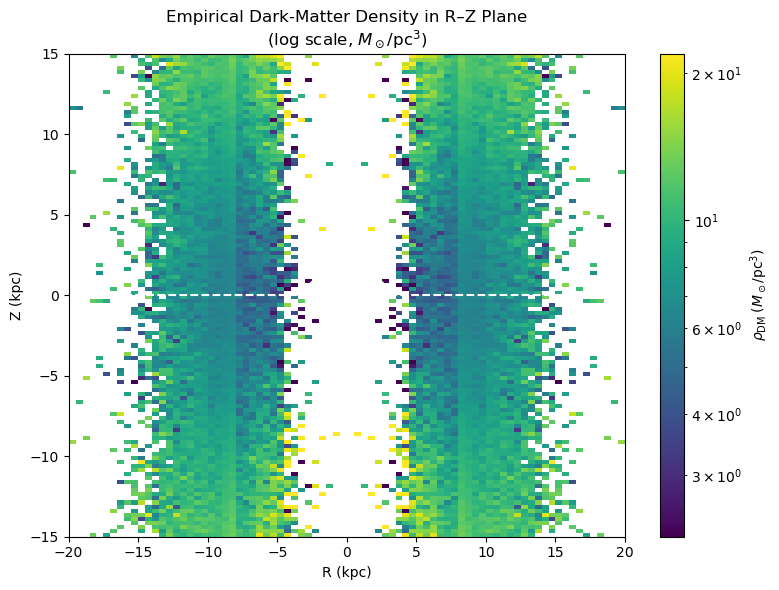

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
from matplotlib.colors import LogNorm

def TwoDPlot(df):
    
    r = np.hypot(df['R'], df['Z'])
    v_dm = df['dark_matter_velocity']
    M_enc = (v_dm**2 * r) / G  # M_sun

    # set limits
    R_edges = np.linspace(0, 60, 121)   # 0 to 60 kpc, 0.5 kpc bins
    Z_edges = np.linspace(-15, 15, 121) # -15 to 15 kpc, 0.25 kpc bins

    # Histogram mass and count
    H_mass, _, _ = np.histogram2d(
        df['R'], df['Z'],
        bins=[R_edges, Z_edges],
        weights=M_enc
    )
    
    H_count, _, _ = np.histogram2d(
        df['R'], df['Z'],
        bins=[R_edges, Z_edges]
    )

    R_centers = 0.5 * (R_edges[:-1] + R_edges[1:])
    dR = R_edges[1] - R_edges[0]
    dZ = Z_edges[1] - Z_edges[0]
    vol = 2 * np.pi * R_centers[:, None] * dR * dZ  # kpc^3

    H_mass_full  = np.vstack((H_mass[::-1, :],  H_mass))
    H_count_full = np.vstack((H_count[::-1, :], H_count))
    vol_full     = np.vstack((vol[::-1, :],     vol))

    density = np.where(H_count_full > 0, H_mass_full / (vol_full * H_count_full), np.nan)
    density_pc3 = density / 1e9  # (1 kpc^3 = 1e9 pc^3)

    R_edges_signed = np.concatenate((-R_edges[::-1], R_edges[1:]))

    fig, ax = plt.subplots(figsize=(8, 6))
    pcm = ax.pcolormesh(
    R_edges_signed, Z_edges,
    density_pc3.T,
    norm=LogNorm(vmin=np.nanpercentile(density_pc3, 1),
                 vmax=np.nanpercentile(density_pc3, 99)),
    shading='auto'
    )

    # Ellipse for bulge: 3 kpc radius, 1.5 kpc half-height
    bulge = Ellipse((0, 0), width=6, height=3,
                edgecolor='white', facecolor='none', lw=1.5)
    ax.add_patch(bulge)

    # Dashed line for disk midplane
    ax.axhline(0, color='white', linestyle='--', linewidth=1.5)

    # Labels and title
    ax.set_xlim(-20, 20)
    ax.set_ylim(-15, 15)
    ax.set_xlabel('R (kpc)')
    ax.set_ylabel('Z (kpc)')
    ax.set_title('Empirical Dark-Matter Density in R–Z Plane\n(log scale, $M_\\odot/\\mathrm{pc}^3$)')

    # Colorbar
    cbar = fig.colorbar(pcm, ax=ax, label=r'$\rho_{\rm DM}\;(M_\odot/\mathrm{pc}^3)$')
    plt.tight_layout()
    plt.show()
    
TwoDPlot(gaia_clean)